In [2]:
import numpy as np
from atlas_ml import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
X = np.array([i for i in range(10)]).reshape(10,1)
Y = np.array([i for i in range(10)]).reshape(10,1)

Data preprocessing from: https://www.tensorflow.org/tutorials/sequences/text_generation

In [4]:
path_to_file = 'Shakespeare.txt'

In [5]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [6]:
vocab = sorted(set(text))

In [7]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [8]:
text_as_int = np.array([char2idx[c] for c in text])

In [9]:
data = text_as_int[:6347700].reshape(100, text_as_int.shape[0]//100)

In [10]:
X = np.expand_dims(data[:-1,:], axis=-1)
Y = np.expand_dims(data[1:,:], axis=-1)

In [11]:
class rec_layer():
    def __init__(self, n_prev, n_next, activation):
        self.WA = init_matrix(n_prev, n_next, activation)
        self.WH = init_matrix(n_next, n_next, activation)
        self.B = init_matrix(1, n_next, activation)
        self.activation = activation()
        
        self.dWA = np.zeros(self.WA.shape)
        self.dWH = np.zeros(self.WH.shape)
        self.dB = np.zeros(self.B.shape)
    
        self.V_dWA = np.zeros(self.WA.shape)
        self.V_dWH = np.zeros(self.WH.shape)
        self.V_dB = np.zeros(self.B.shape)
        
    def forward(self, A0 , H0):
        self.Z = np.einsum('ln,ml-> mn', self.WA, A0) + np.einsum('ln,ml-> mn', self.WH, H0) +  self.B
        self.A = self.activation.activate(self.Z)
        return self.A
    
    def grad(self, dA, dH, A0, H0, m):
        dAdZ = self.activation.diff(self.Z)
        self.dZ = np.multiply(dA + dH , dAdZ)
        
        self.dWA = (1./m)*np.einsum('mn,ml->ln',self.dZ, A0)
        self.dWH = (1./m)*np.einsum('mn,ml->ln',self.dZ, H0)
        self.dB = (1./m)*(np.einsum('mn->n',self.dZ))
        
        dA_prev = np.einsum('ln, mn->ml',self.WA, self.dZ)
        dH_prev = np.einsum('ln, mn->ml',self.WH, self.dZ)        
        return dA_prev, dH_prev
    
    def out_grad(self, dZ, dH, A0, H0, m):
        dAdZ = self.activation.diff(self.Z)
        self.dZ = dZ + np.multiply(dH , dAdZ)
        self.dWA = (1./m)*np.einsum('mn,ml->ln',self.dZ, A0)
        self.dWH = (1./m)*np.einsum('mn,ml->ln',self.dZ, H0)
        self.dB = (1./m)*(np.einsum('mn->n',self.dZ))
        
        dA_prev = np.einsum('ln, mn->ml',self.WA, self.dZ) 
        dH_prev = np.einsum('ln, mn->ml',self.WH, self.dZ) 
        return dA_prev, dH_prev
        
    def step(self, lr, beta):
        self.V_dWA = (beta * self.V_dWA + (1. - beta) * self.dWA)
        self.V_dWH = (beta * self.V_dWH + (1. - beta) * self.dWH)
        self.V_dB = (beta * self.V_dB + (1. - beta) * self.dB)
        self.WA = self.WA - lr*self.V_dWA
        self.WH = self.WH - lr*self.V_dWH
        self.B = self.B - lr*self.V_dB

BookKeeping gains dimension in Time and therefore definition of RNN requires use of lists and for loops. Using these on top of the atlas_ml NN architure adds significant overheads making training extremely slow compared to A.Karpathy's Vanilla RNN(presented at the end)

In [12]:
class RNN:
    def __init__(self, X_size, Y_size, lossfn):
        self.n_hidden = 100
        self.L1 = rec_layer(X_size, self.n_hidden, tanh)
        self.L2 = layer(self.n_hidden, Y_size, softmax)
        self.lossfn = lossfn()
        self.Y_size = Y_size
        
    def clear_book(self, batch_size=4):
        self.total_loss = 0
        self.loss = 0
        self.L1Z = list()
        self.L1H = [np.zeros([batch_size, self.n_hidden])]
        self.L2Z = list()
        self.L2H = list()
        
        self.L2dW = np.zeros(self.L2.W.shape)
        self.L2dB = np.zeros(self.L2.B.shape)
        self.L1dWH = np.zeros(self.L1.WH.shape)
        self.L1dWA = np.zeros(self.L1.WA.shape)
        self.L1dB = np.zeros(self.L1.B.shape)
    
    def generate(self, prompt, seq_len):
        self.clear_book()
        seq = [one_hot(np.array([[char2idx[prompt]]]), self.Y_size)]
        L1H = np.zeros([1, self.n_hidden])
        for i in range(seq_len):
            L1H = self.L1.forward(seq[i], L1H)
            seq.append(self.L2.forward(self.L1.A))
        return seq
    
    def f_pass(self, X):
        for i in range(X.shape[0]):
            self.L1H.append(self.L1.forward(one_hot(X[i],self.Y_size), self.L1H[i]))
            self.L1Z.append(self.L1.Z)
            
            self.H = self.L2.forward(self.L1.A)
            self.L2H.append(self.H)
            self.L2Z.append(self.L2.Z)
        #self.L1H[-1]=np.zeros([batch_size, self.n_hidden])
        return np.array([inv_one_hot(i) for i in self.L2H])
    
    def back_prop(self, X, Y, batch_size,reg_lambda=0):
        HtdH = np.zeros([batch_size, self.n_hidden])
        for i in range(X.shape[0]-1,-1,-1):
            self.L2.Z = self.L2Z[i]
            self.L1.Z = self.L1Z[i]
            
            m = batch_size
            Y2 = one_hot(Y[i],self.Y_size)

            self.loss = self.lossfn.get_loss(self.L2H[i],Y2)
            self.total_loss += self.loss
            
            L2dZ = self.lossfn.diff(self.L2H[i],Y2)
            
            L2dH = self.L2.out_grad(L2dZ, self.L1H[i], m)
            _, HtdH = self.L1.grad(L2dH, HtdH, one_hot(X[i],self.Y_size), self.L1H[i+1], m) 
            
            self.L2dW += self.L2.dW 
            self.L2dB += self.L2.dB
            self.L1dWH += self.L1.dWH
            self.L1dWA += self.L1.dWA
            self.L1dB += self.L1.dB

        self.L2.dW = np.clip(self.L2dW, -5, 5, out=self.L2dW) 
        self.L2.dB = np.clip(self.L2dB, -5, 5, out=self.L2dB)
        self.L1.dWH = np.clip(self.L1dWH, -5, 5, out=self.L1dWH)
        self.L1.dWA = np.clip(self.L1dWA, -5, 5, out=self.L1dWA)
        self.L1.dB = np.clip(self.L1dB, -5, 5, out=self.L1dB)
    
    def optim(self, lr, beta=0):
        self.L1.step(lr,beta)
        self.L2.step(lr,beta)

In [13]:
a = [one_hot(np.array([[char2idx['I']]]), len(vocab))]
a[0].shape

(1, 82)

In [14]:
def BPTT(batch_size,X,Y, model,lr,beta,reg_lambda=0):
    m = np.shape(X)[1]
    H = np.zeros(X.shape)
    for i in range(0,m-m//batch_size,batch_size):
        X_batch = X[:,i:i+batch_size]
        Y_batch = Y[:,i:i+batch_size]
        model.clear_book(batch_size)
        H[:,i:i+batch_size]= model.f_pass(X_batch)
        model.back_prop(X_batch, Y_batch, batch_size, reg_lambda)
        model.optim(lr, beta) 
    O = H.flatten()
    L = Y.flatten()
    tr_acc = model_accuracy(O,L)    
    return model.loss, tr_acc, O, L

In [15]:
n_out = len(vocab)
n_in = len(vocab)
rnn = RNN(n_in, n_out, CE_loss)

In [16]:
rnn.clear_book(400)
H = rnn.f_pass(X[:,:400,:])
O = H.flatten()

In [18]:
batch_size = 16

lr = 0.1

n_epochs = 10

lr_decay = 1

data_size = X.shape[1]

beta = 0.99

In [19]:
loss, tr_acc, O, L = BPTT(16,X,Y,rnn,lr, beta)
loss, tr_acc  

(0.3386385586021976, 0.06508234987841774)

In [23]:
seq = rnn.generate('.',1000)
print(''.join([idx2char[int(inv_one_hot(i))] for i in seq]))

. .la a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  st et a st ehs a t  

In [24]:
s = ''.join(idx2char[int(i)] for i in O[:1500])
s

"RYsRVVVRRORbsRRRYYVYRsVYORbsRRVVQYRbQVVQbVROYbbVfsVbYVVVYYbVbRQfR.VYfRYbVVVRRYRVYR'RRRYVVRsVRRYYsRY_YsR'RRRR'YsVRsVRR3sYYYVsVRRRYYRRRVRYRYfQVVRYVRRRVRs_VRbYRRVYRVRYYVRR.VYRRRsOVRbRVRVVRYVYRRVR3VYRYbVVRRYbRRRYsVRYRRRYYOVRfVYRQYRRYQRYR3VYRYbVVVRROYsbVYYVROVYRbYRRRRRRYVRRRYYRVffRR.RYRYfQVVRYVRRRVRVRYsVRbR.V.YYRbYYROVYRbYRRR.RRYVRR.YRRVffR..R..YfQVV.RVRRVR.VYsVROVYRbRRRR.RRYVRR.YRRV..R..R....Q...RVVRRRR_.YsOORRRR.R_O.RRR.VRV.RYVYRR.R3VYRYbVVRRYsRs.VVRbR.VRR.VY.VbRRs..RV.RVYR.YRRYVR...RRV..VRRVR.....R.RRRR..s..sRVRR..V.V.RYb..YRV.RR.RRYVR..Y.YVVRRR..Rs..V.R.V..Y....R..YR...V.YR..R.YVR..Y.YVRR.V..V.V.R....Y....R..YR.....YR..R.Y.R....YVVRR......R.........R.........R...R.R......R...R..........RRVV......V..........R......R.........R..........VV...R..R.....RR.V..........R...R.......R.............R........R...R............................................................................................................................................................................................

In [1770]:
def train(model, X, Y, X_test, Y_test, metric, n_epochs=10, \
    batch_size=4, lr=0.0003, lr_decay=1, beta=0, reg_lambda=0, show_test_acc=True, shuffle_data=True):
    data_size = X.shape[0]
    for e in range(n_epochs):
        #shuffle dataset
        np.random.seed(138)

        if shuffle_data:
            shuffle_index = np.random.permutation(data_size)
            X, Y = X[shuffle_index,:], Y[shuffle_index,:]

        #SGD with momentum
        model.loss=0
        model.total_loss=0
        loss, tr_acc, O, L = BPTT(batch_size,X,Y,model,lr, beta)
        lr = lr*lr_decay
        s = ''.join(idx2char[int(i)] for i in O[:1500])
        print(s)
        if show_test_acc:
            m = np.shape(X_test)[0]
            H = np.zeros(Y_test.shape)
            for i in range(0,m,batch_size):
                X_test_batch = X_test[i:i+batch_size]
                H[i:i+batch_size] = model.f_pass(X_test_batch)
            O = inv_one_hot(H)
            L = inv_one_hot(Y_test)
            acc = metric(O,L)
        else:
            acc = 0
            
        plt.plot(e,tr_acc, 'bo')
        plt.plot(e,acc,'ro')
        plt.plot(e,loss,'gx')
        clear_output()
        print(f"epoch:{e+1}/{n_epochs} | Loss:{loss:.4f} \
Train Accuracy: {tr_acc:.4f} | Test_Accuracy:{acc:.4f}")
        
    #plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.show()

epoch:6/10 | Loss:0.4423 Train Accuracy: 0.2071 | Test_Accuracy:0.0000


KeyboardInterrupt: 

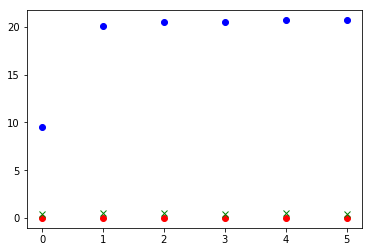

In [1846]:
train(rnn, X, Y, X, Y, model_accuracy, n_epochs, \
    batch_size, lr, lr_decay, beta, show_test_acc=False,shuffle_data=True)

In [202]:
inv_one_hot(rnn.H)

array([[3.]])

Referred to A.Karpathy's Vanilla RNN for inspiration.

In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
data = open('Shakespeare.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[10], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ) )

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
n += 1 # iteration counter 